# CS5814: Assignment 2

## Problem 2

This problem involves implementing a Convolutional Neural Network to classify images within the MNIST and CIFAR-100 daatasets. Information on these datasets are available here: https://en.wikipedia.org/wiki/MNIST_database and https://www.cs.toronto.edu/~kriz/cifar.html

## TODO update image descriptions once displayed.

### Imports and config

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Supressing Jupyter Notebook torchvision installation error 

import torch
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

import os
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn import metrics
import seaborn as sns
from tqdm import tqdm

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# Setting random seeds

RANDOM_SEED = 3819969

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
# Checking GPU configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Data preprocessing

Creating DataLoaders for the MNIST and CIFAR100 datasets, all data is used within the default train/test sets.

A minibatch size of 32 is used for both datasets.

In [5]:
def download_data_MNIST():
    
    # Ratio of data to keep (100%)
    keep_ratio = 1
    
    # Train data
    train = datasets.MNIST("", train=True, download=True,
                           transform=transforms.Compose(
                               [transforms.ToTensor()]))
    train = data_utils.Subset(train, torch.randperm(len(train))[:int(keep_ratio * len(train))])

    # Testing data
    test = datasets.MNIST("", train=False, download=True,
                          transform=transforms.Compose(
                              [transforms.ToTensor()]))
    test = data_utils.Subset(test, torch.randperm(len(test))[:int(keep_ratio * len(test))])

    # Generating DataLoader
    trainset = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
    testset = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)

    return trainset, testset

trainset_MNIST, testset_MNIST = download_data_MNIST()

In [6]:
def download_data_CIFAR100():
    
    # Ratio of data to keep (100%)
    keep_ratio = 1
    
    # Train data
    train = datasets.CIFAR100("", train=True, download=True,
                           transform=transforms.Compose(
                               [transforms.ToTensor()]))
    train = data_utils.Subset(train, torch.randperm(len(train))[:int(keep_ratio * len(train))])

    # Testing data
    test = datasets.CIFAR100("", train=False, download=True,
                          transform=transforms.Compose(
                              [transforms.ToTensor()]))
    test = data_utils.Subset(test, torch.randperm(len(test))[:int(keep_ratio * len(test))])

    # Loading the datasets
    trainset = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
    testset = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)

    return trainset, testset

trainset_CIFAR100, testset_CIFAR100 = download_data_CIFAR100()

Files already downloaded and verified
Files already downloaded and verified


## Network Definitions

### CNN

CNN definition using:

    Conv:                 [variable input size based on dataset channels, 16 output channels, 3x3 kernal, stride of 1]
    ReLU
    MaxPool:              [2x2]
    Conv:                 [16 input channels, 32 output channels, 5x5 kernal, stride of 1]
    RelU
    MaxPool:              [2x2]
    Fully connected:      [variable input size based on dataset channels, 1024 output channels]
    Fully Connected:      [1024 input channels, number of classes output (10 or 100)]
    Softmax

In [7]:
class CNN(nn.Module):
    def __init__(self, input_channels = 1, fc_width=512, classes=10):
        
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=input_channels,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=0,                  
        ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=5,              
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        
        
        self.fc_1 = nn.Linear(fc_width, 1024).to(device)
        self.fc_2 = nn.Linear(1024, classes).to(device)
        
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        
        # flatten the output of conv2 to (batch_size, X)
        x = torch.flatten(x, start_dim=1, end_dim=- 1)   
        x = self.fc_1(x)
        x = self.fc_2(x)
                
        output = self.softmax(x)
        
        return output

## Training

In [29]:
def training_base(model, optimizer, criterion, epochs, testset, trainset, classes=100):
    # Main training loop for a given model, optimizer and evaluation criterion
    
    loss = 0  
    weight_updates = 0  # Number of weight updates conducted

    # Arrays for tracking training metrics
    train_loss_array = []
    metric_list = []
    train_accuracy_array = []
    val_loss_array = []
    
    # Start training
    for epoch in range(epochs):
        
        train_prediction_list = []
        train_label_list = []
        
        mini_batch_id = 0
        correct = 0
        total = 0
        
        for X, y in tqdm(trainset):
            
            X, y = X.to(device), y.to(device)
            model.zero_grad()
            
            # Forward step
            output = model.forward(X)
                        
            train_prediction_list.append(torch.argmax(output, dim=1).cpu().numpy())
            train_label_list.append(y.cpu().numpy())
            
            # TODO - tidy up this messy expression
            batch_accuracy = np.count_nonzero(torch.argmax(output, dim=1).cpu().numpy()==y.cpu().numpy())/len(y.cpu().numpy())
            train_accuracy_array.append(batch_accuracy)
            
            # Backward step
            loss = criterion(output, y)           
            loss.backward()
            optimizer.step()
            
            # Updaing loss arrays
            train_loss_array.append(loss.item())

            # Validation
            if mini_batch_id % 100 == 0 or weight_updates==0:
                
                val_loss_local_list = []
                prediction_list = []
                label_list  = []
            
                model.eval()
                for X, y in testset:
                    X, y = X.to(device), y.to(device)

                    val_output = model(X)
                    val_loss = criterion(val_output, y)
                    val_loss_local_list.append(val_loss.item())
                    
                    prediction_list.append(torch.argmax(val_output, dim=1).cpu().numpy())
                    label_list.append(y.cpu().numpy())
                    
                val_loss_array.append(np.average(val_loss_local_list))
                    
                # Combining labels and predictions from batches of testset
                label_out = np.concatenate(label_list).ravel()
                pred_out = np.concatenate(prediction_list).ravel()
                
                target_names_int = [i for i in range(classes)]
                f1 = f1_score(label_out, pred_out, average=None, labels=target_names_int)
                precision = metrics.precision_score(label_out, pred_out, average=None, labels=target_names_int)
                recall = metrics.recall_score(label_out, pred_out, average=None, labels=target_names_int)
                accuracy_total = metrics.accuracy_score(label_out, pred_out)

                cm = confusion_matrix(label_out, pred_out, labels=target_names_int)
                accuracy_class = cm.diagonal()/cm.sum(axis=1)

                metric_list.append([precision, recall, f1, accuracy_class])

                #print("Val acc: {:.4f}".format(accuracy_total))
                
                
            model.train()

            mini_batch_id += 1
            weight_updates+= 1
            
            
        train_label_out = np.concatenate(train_label_list).ravel()
        train_pred_out = np.concatenate(train_prediction_list).ravel()
        train_accuracy_total = metrics.accuracy_score(train_label_out, train_pred_out)
        print("Epoch: {}, Train loss: {:.4f},Val los: {:.4f}, Train acc: {:.4f}, ".format(epoch,loss.item(),
                                                                                        val_loss_array[-1],
                                                                                         train_accuracy_total))
            
    return(model, metric_list, train_loss_array, train_accuracy_array, val_loss_array)

## MNIST Dataset
### Training

In [30]:
classes=10

model = CNN(input_channels=1,
           fc_width=512,
           classes=classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 5

model, MNIST_metric_list, train_loss_array, train_accuracy_array, val_loss_array = training_base(model,
                                    optimizer,
                                    criterion,
                                    epochs,
                                    testset=testset_MNIST,
                                    trainset=trainset_MNIST,
                                   classes=classes)

100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:56<00:00, 32.95it/s]


Epoch: 0, Train loss: 1.4813,Val los: 1.4964, Train acc: 0.9288, 


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:54<00:00, 34.15it/s]


Epoch: 1, Train loss: 1.4924,Val los: 1.4960, Train acc: 0.9651, 


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:54<00:00, 34.14it/s]


Epoch: 2, Train loss: 1.4612,Val los: 1.4879, Train acc: 0.9716, 


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:56<00:00, 33.36it/s]


Epoch: 3, Train loss: 1.5264,Val los: 1.4842, Train acc: 0.9740, 


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:53<00:00, 34.95it/s]

Epoch: 4, Train loss: 1.4924,Val los: 1.4832, Train acc: 0.9750, 


### Results

In [31]:
def movingaverage(interval, window_size=10):
    """Helper function to calulate moving averages"""
    
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

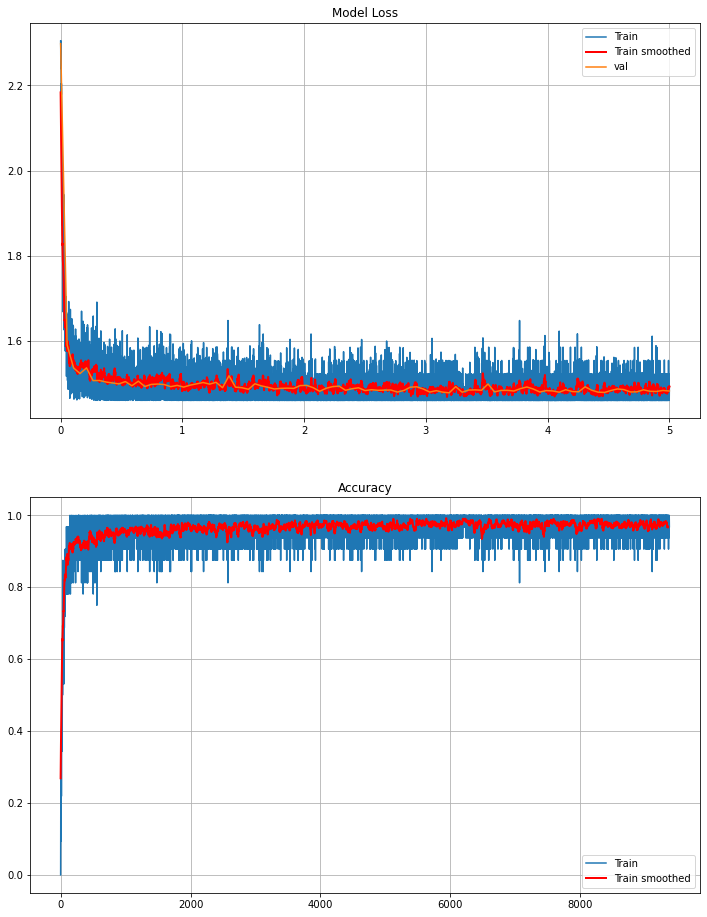

In [33]:
fig, axs = plt.subplots(2, 1)
fig.set_size_inches(12, 16)

axs[0].plot(np.linspace(0, 5, len(train_loss_array)), train_loss_array, label="Train")


smoothed_train_loss = movingaverage(train_loss_array,20)[10:-10]
axs[0].plot(np.linspace(0, 5, len(smoothed_train_loss)), smoothed_train_loss,
                        label="Train smoothed", linewidth=2, color="red")
axs[0].plot(np.linspace(0, 5, len(val_loss_array)), val_loss_array,label = "val") 


axs[0].set_title("Model Loss")
axs[0].legend(loc="upper right")
axs[0].grid()

axs[1].plot(train_accuracy_array, label="Train")
axs[1].plot(movingaverage(train_accuracy_array,20)[10:-10],label="Train smoothed",
            linewidth=2, color="red",)
axs[1].set_title("Accuracy")
axs[1].legend()
axs[1].grid()


plt.show()

In [11]:
MNIST_metric_list = np.array(MNIST_metric_list)
class_avg = MNIST_metric_list.sum(axis=2)/classes

print("Final test set performance metrics:\n(averaged across {} classes)\n------------------------".format(classes))
metric_labels = ['precision', 'recall', 'f1', 'accuracy']
for i, label in enumerate(metric_labels):
    print("{0}: {1:.4f}".format(label, class_avg[-1,i]))

Final test set performance metrics:
(averaged across 10 classes)
------------------------
precision: 0.9772
recall: 0.9773
f1: 0.9771
accuracy: 0.9773


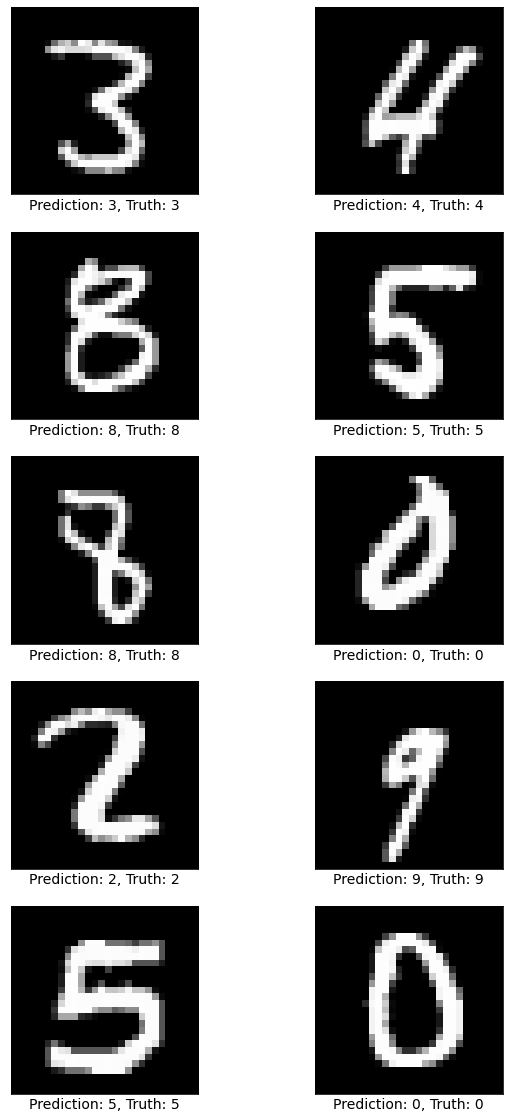

In [61]:
for X, y in testset_MNIST:
    X, y = X.to(device), y.to(device)
    
    
    fig, axs = plt.subplots(nrows=5, ncols=2)
    fig.set_size_inches(10, 20)

    for i, ax in enumerate(axs.reshape(-1)):        
        

        ax.imshow(X[i][0].cpu(), cmap='gray')
        
        output = model(X[i].reshape(-1, 1, 28, 28))
        prediction = torch.argmax(output, dim=1).cpu().numpy()[0]
        turth = y[i].item()
        
        ax.set_xlabel("Prediction: {}, Truth: {}".format(prediction, turth), fontsize=14)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        
    fig.show()
    break

Conv 1 Activation Maps


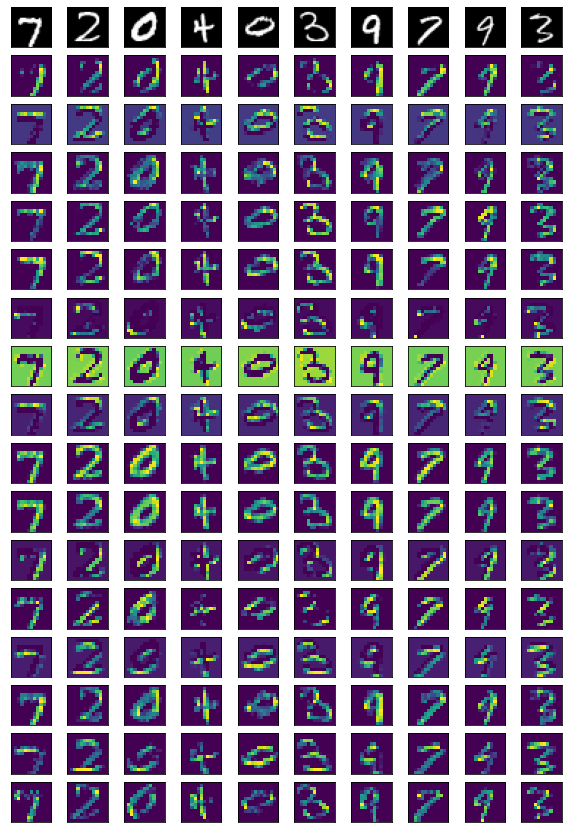

In [66]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

for X, y in testset_MNIST:
    X, y = X.to(device), y.to(device)
    
    fig, axarr = plt.subplots(nrows = act.size(0)+1, ncols=10, figsize=(7,7))
    fig.set_size_inches(10, 15)

    for i in range(10):        
        
        model.conv1[0].register_forward_hook(get_activation('conv1'))
        data=X[i].reshape(-1, 1, 28, 28)
        output_test = model(data)

        act = activation['conv1'].squeeze()

        for idx in range(1, act.size(0) +1):
            axarr[idx][i].imshow(act[idx-1].cpu())
            axarr[idx][i].set_yticklabels([])
            axarr[idx][i].set_xticklabels([])
            axarr[idx][i].set_xticks([])
            axarr[idx][i].set_yticks([])
            
        axarr[0][i].imshow(data[0][0].cpu(), cmap='gray')
        axarr[0][i].set_yticklabels([])
        axarr[0][i].set_xticklabels([])
        axarr[0][i].set_xticks([])
        axarr[0][i].set_yticks([])
    
    print("Conv 1 Activation Maps")
    plt.show()
    break

Conv 2 Activation Maps


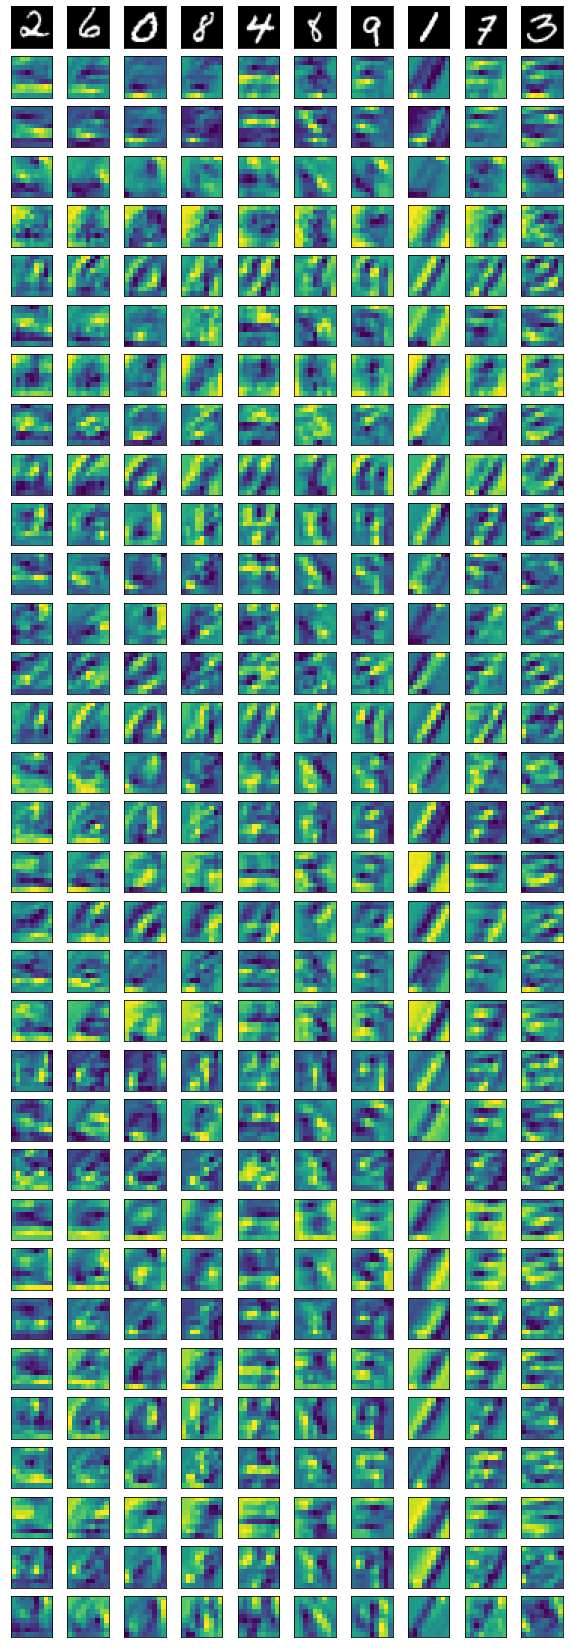

In [68]:
for X, y in testset_MNIST:
    X, y = X.to(device), y.to(device)
    
    fig, axarr = plt.subplots(nrows = act.size(0)+1, ncols=10, figsize=(7,7))
    fig.set_size_inches(10, 30)

    for i in range(10):        
        
        model.conv2[0].register_forward_hook(get_activation('conv2'))
        data=X[i].reshape(-1, 1, 28, 28)
        output_test = model(data)

        act = activation['conv2'].squeeze()

        for idx in range(1, act.size(0)+1):
            axarr[idx][i].imshow(act[idx-1].cpu())
            axarr[idx][i].set_yticklabels([])
            axarr[idx][i].set_xticklabels([])
            axarr[idx][i].set_xticks([])
            axarr[idx][i].set_yticks([])
        
        axarr[0][i].imshow(data[0][0].cpu(), cmap='gray')
        axarr[0][i].set_yticklabels([])
        axarr[0][i].set_xticklabels([])
        axarr[0][i].set_xticks([])
        axarr[0][i].set_yticks([])
    
    print("Conv 2 Activation Maps")
    plt.show()
    break

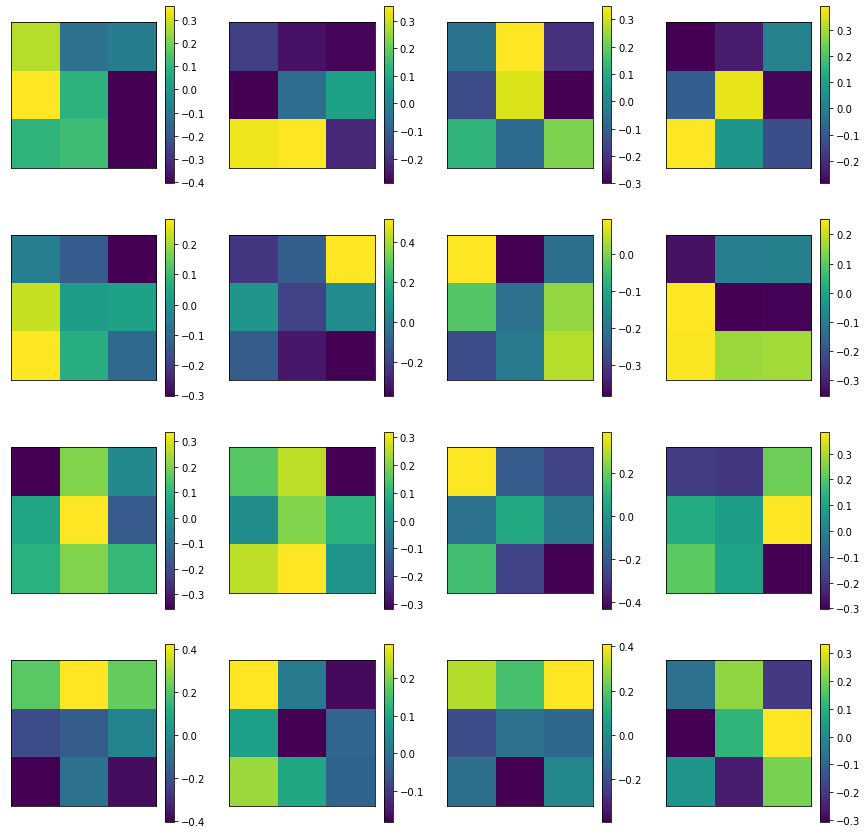

In [119]:
conv1_weights = model.conv1[0].weight.cpu().detach().numpy()

fig, axs = plt.subplots(nrows = 4, ncols=4, figsize=(7,7))
fig.set_size_inches(15, 15)

for filter_id, ax in enumerate(axs.reshape(-1)):

    plot = ax.imshow(conv1_weights[filter_id][0])
    fig.colorbar(plot, ax=ax)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()


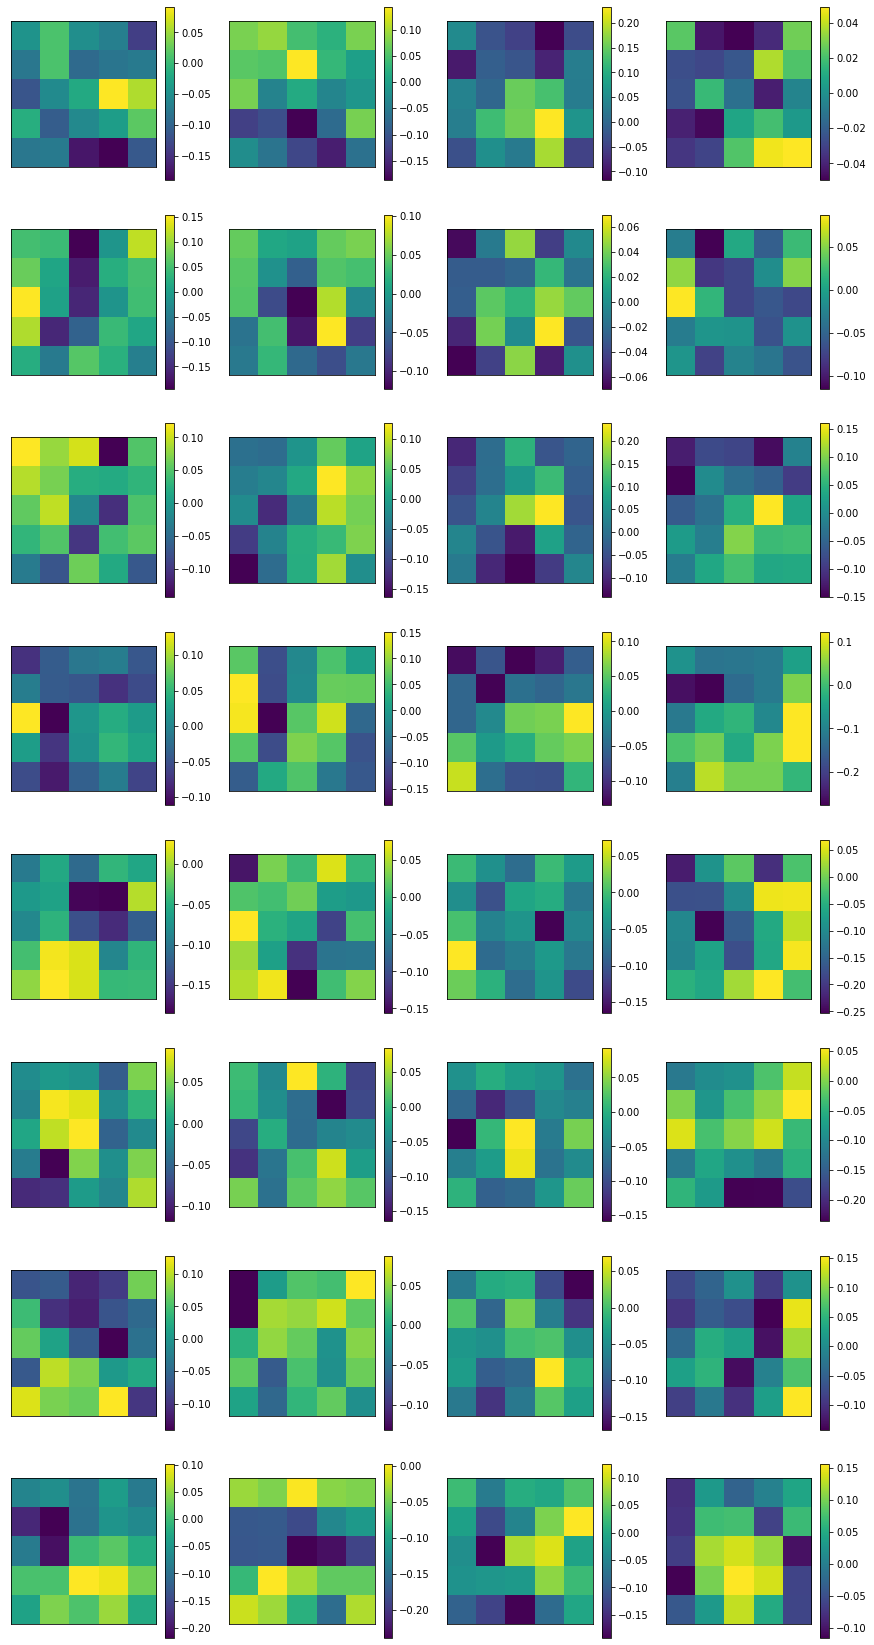

In [117]:
conv2_weights = model.conv2[0].weight.cpu().detach().numpy()

fig, axs = plt.subplots(nrows = 8, ncols=4, figsize=(7,7))
fig.set_size_inches(15, 30)

for filter_id, ax in enumerate(axs.reshape(-1)):

    plot = ax.imshow(conv2_weights[filter_id][0])
    fig.colorbar(plot, ax=ax)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()


## CIFAR100 Dataset
### Training

In [120]:
classes=100

CIFAR_model = CNN(input_channels=3,
           fc_width=800,
           classes=classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
epochs = 1

CIFAR_model, CIFAR_metric_list, CIFAR_train_loss_array, CIFAR_mini_batch_accuracy = training_base(CIFAR_model,
                                                            optimizer,
                                                            criterion,
                                                            epochs,
                                                            testset=testset_CIFAR100,
                                                            trainset=trainset_CIFAR100,
                                                            classes=classes)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:24<00:00, 63.78it/s]

Train acc: 0.0107


### Results

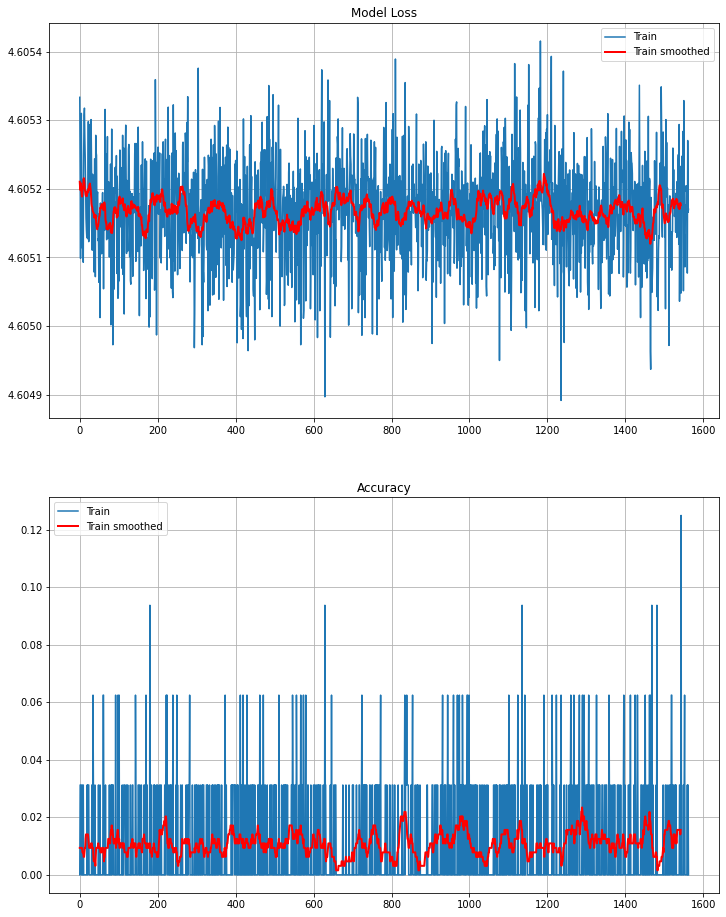

In [121]:
fig, axs = plt.subplots(2, 1)
fig.set_size_inches(12, 16)

axs[0].plot(CIFAR_train_loss_array, label="Train")
axs[0].plot(movingaverage(CIFAR_train_loss_array,20)[10:-10],label="Train smoothed",
            linewidth=2, color="red",)
axs[0].set_title("Model Loss")
axs[0].legend(loc="upper right")
axs[0].grid()

axs[1].plot(CIFAR_mini_batch_accuracy, label="Train")
axs[1].plot(movingaverage(CIFAR_mini_batch_accuracy,20)[10:-10],label="Train smoothed",
            linewidth=2, color="red",)
axs[1].set_title("Accuracy")
axs[1].legend()
axs[1].grid()


plt.show()

In [122]:
MNIST_metric_list = np.array(MNIST_metric_list)
class_avg = MNIST_metric_list.sum(axis=2)/classes

print("Final test set performance metrics:\n(averaged across {} classes)\n------------------------".format(classes))
metric_labels = ['precision', 'recall', 'f1', 'accuracy']
for i, label in enumerate(metric_labels):
    print("{0}: {1:.4f}".format(label, class_avg[-1,i]))

Final test set performance metrics:
(averaged across 100 classes)
------------------------
precision: 0.0977
recall: 0.0977
f1: 0.0977
accuracy: 0.0977


In [156]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

cifar_100_labels = unpickle('cifar-100-python\meta')
cifar_100_fined_labels = cifar_100_labels['fine_label_names']

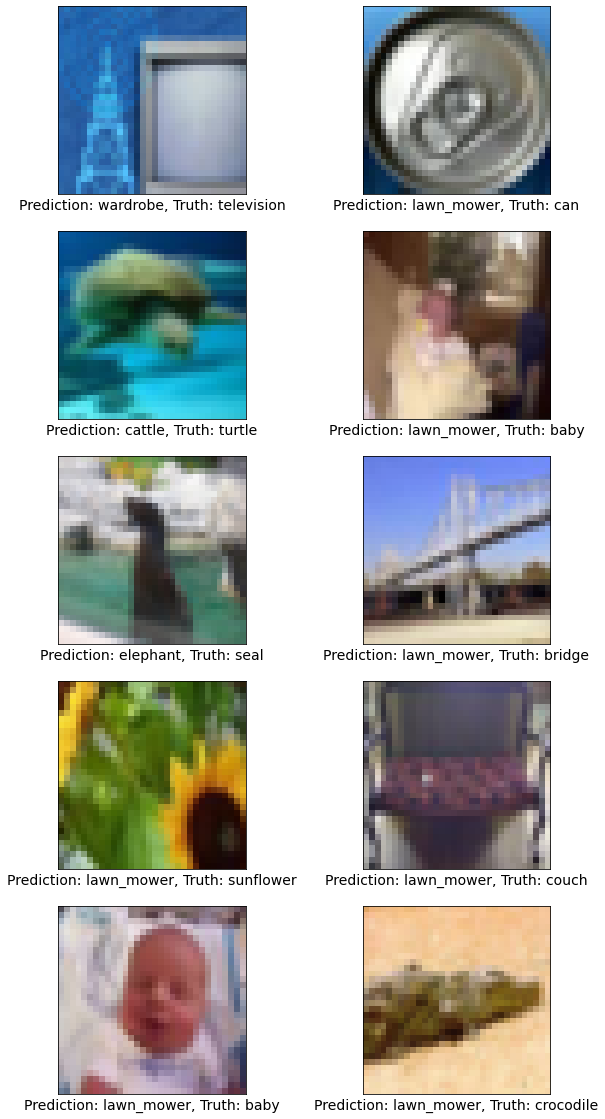

In [157]:
for X, y in testset_CIFAR100:
    X, y = X.to(device), y.to(device)

    fig, axs = plt.subplots(nrows=5, ncols=2)
    fig.set_size_inches(10, 20)

    for i, ax in enumerate(axs.reshape(-1)):        
        
        
        image_data = np.moveaxis(X[i].cpu().numpy(),0,-1)
        ax.imshow(image_data)
        
        output = CIFAR_model(X[i].reshape(-1, 3, 32, 32))
        prediction = torch.argmax(output, dim=1).cpu().numpy()[0]
        turth = y[i].item()
        
        ax.set_xlabel("Prediction: {}, Truth: {}".format(cifar_100_fined_labels[prediction], cifar_100_fined_labels[turth]), fontsize=14)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        
    fig.show()
    break

Conv 1 Activation Maps


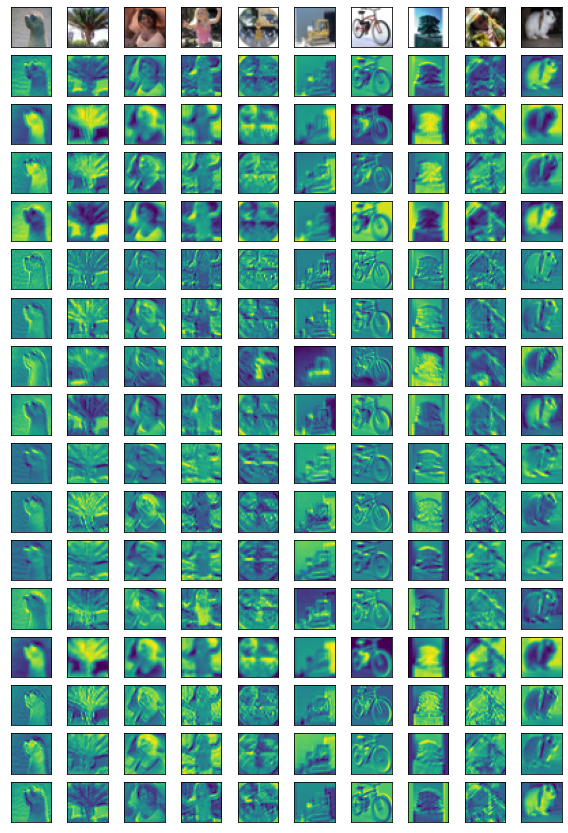

In [166]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

for X, y in testset_CIFAR100:
    X, y = X.to(device), y.to(device)
    
    fig, axarr = plt.subplots(nrows = act.size(0)+1, ncols=10, figsize=(7,7))
    fig.set_size_inches(10, 15)

    for i in range(10):        
        
        CIFAR_model.conv1[0].register_forward_hook(get_activation('conv1'))
        data=X[i].reshape(-1, 3, 32, 32)
        output_test = CIFAR_model(data)

        act = activation['conv1'].squeeze()

        for idx in range(1, act.size(0) +1):
            axarr[idx][i].imshow(act[idx-1].cpu())
            axarr[idx][i].set_yticklabels([])
            axarr[idx][i].set_xticklabels([])
            axarr[idx][i].set_xticks([])
            axarr[idx][i].set_yticks([])
        
        image_data = np.moveaxis(X[i].cpu().numpy(),0,-1)
        axarr[0][i].imshow(image_data)
        axarr[0][i].set_yticklabels([])
        axarr[0][i].set_xticklabels([])
        axarr[0][i].set_xticks([])
        axarr[0][i].set_yticks([])
        
    print("Conv 1 Activation Maps")
    plt.show()
    break

Conv 2 Activation Maps


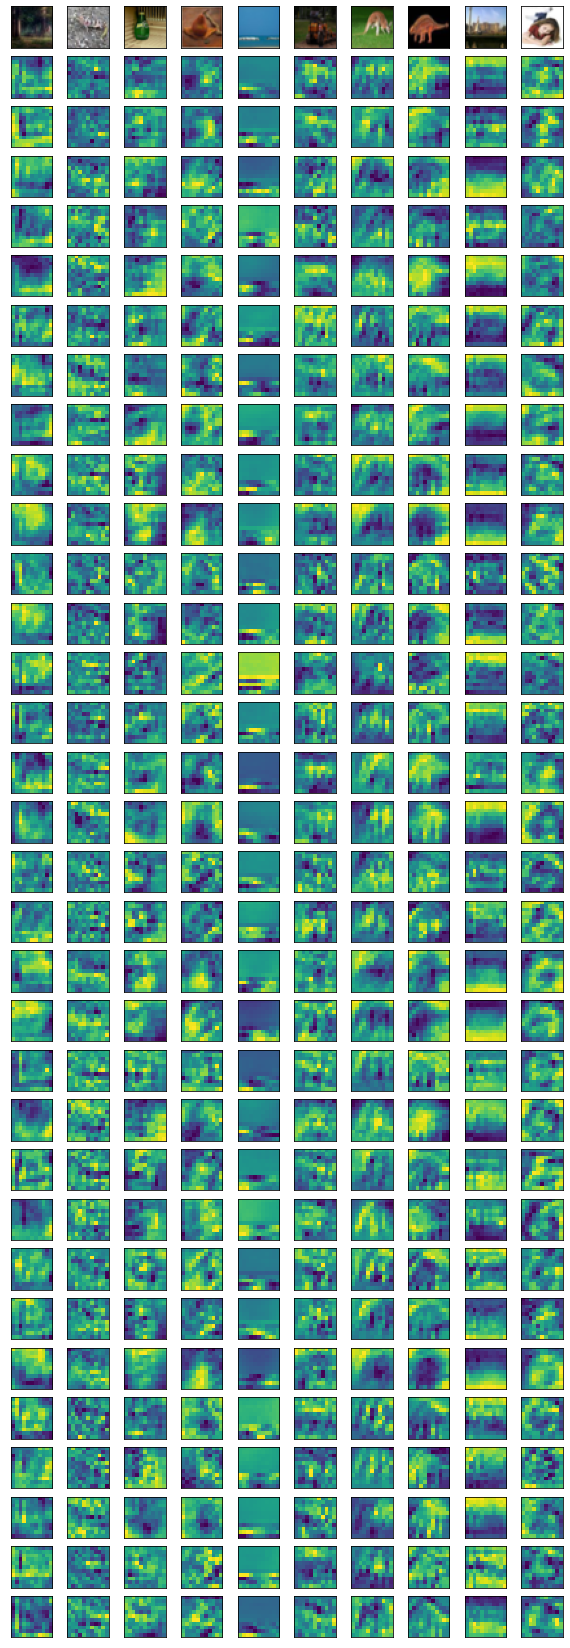

In [174]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

for X, y in testset_CIFAR100:
    X, y = X.to(device), y.to(device)
    
    fig, axarr = plt.subplots(nrows = act.size(0)+1, ncols=10, figsize=(7,7))
    fig.set_size_inches(10, 30)

    for i in range(10):        
        
        CIFAR_model.conv2[0].register_forward_hook(get_activation('conv2'))
        data=X[i].reshape(-1, 3, 32, 32)
        output_test = CIFAR_model(data)

        act = activation['conv2'].squeeze()

        for idx in range(1, act.size(0) +1):
            axarr[idx][i].imshow(act[idx-1].cpu())
            axarr[idx][i].set_yticklabels([])
            axarr[idx][i].set_xticklabels([])
            axarr[idx][i].set_xticks([])
            axarr[idx][i].set_yticks([])
        
        image_data = np.moveaxis(X[i].cpu().numpy(),0,-1)
        axarr[0][i].imshow(image_data)
        axarr[0][i].set_yticklabels([])
        axarr[0][i].set_xticklabels([])
        axarr[0][i].set_xticks([])
        axarr[0][i].set_yticks([])
        
    print("Conv 2 Activation Maps")
    plt.show()
    break

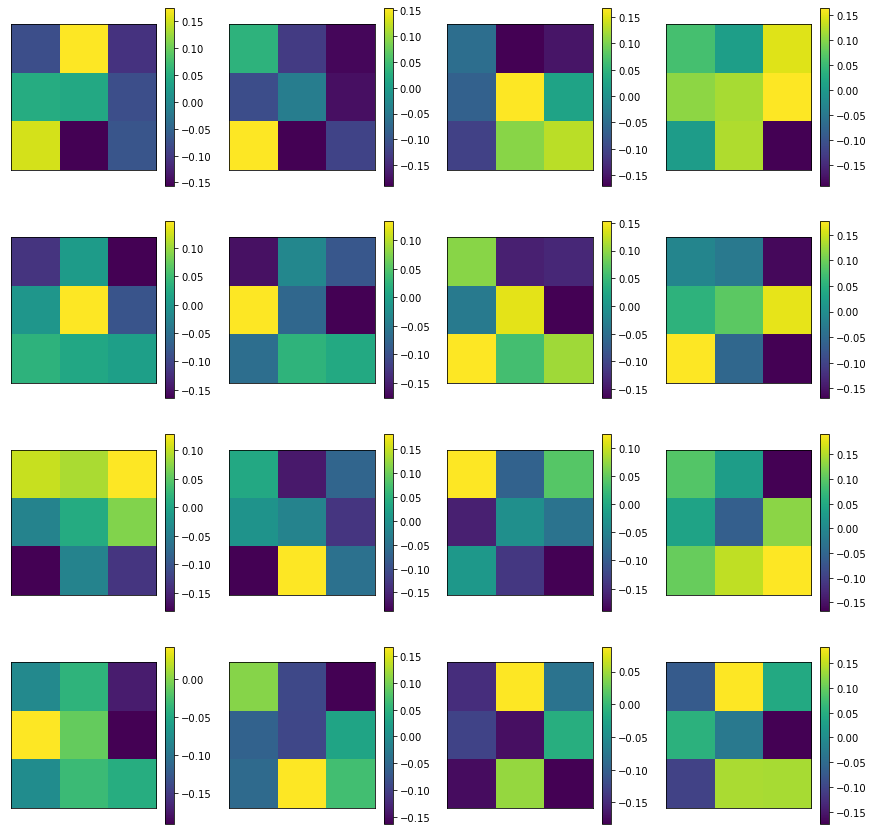

In [172]:
conv1_weights = CIFAR_model.conv1[0].weight.cpu().detach().numpy()

fig, axs = plt.subplots(nrows = 4, ncols=4, figsize=(7,7))
fig.set_size_inches(15, 15)

for filter_id, ax in enumerate(axs.reshape(-1)):

    plot = ax.imshow(conv1_weights[filter_id][0])
    fig.colorbar(plot, ax=ax)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()


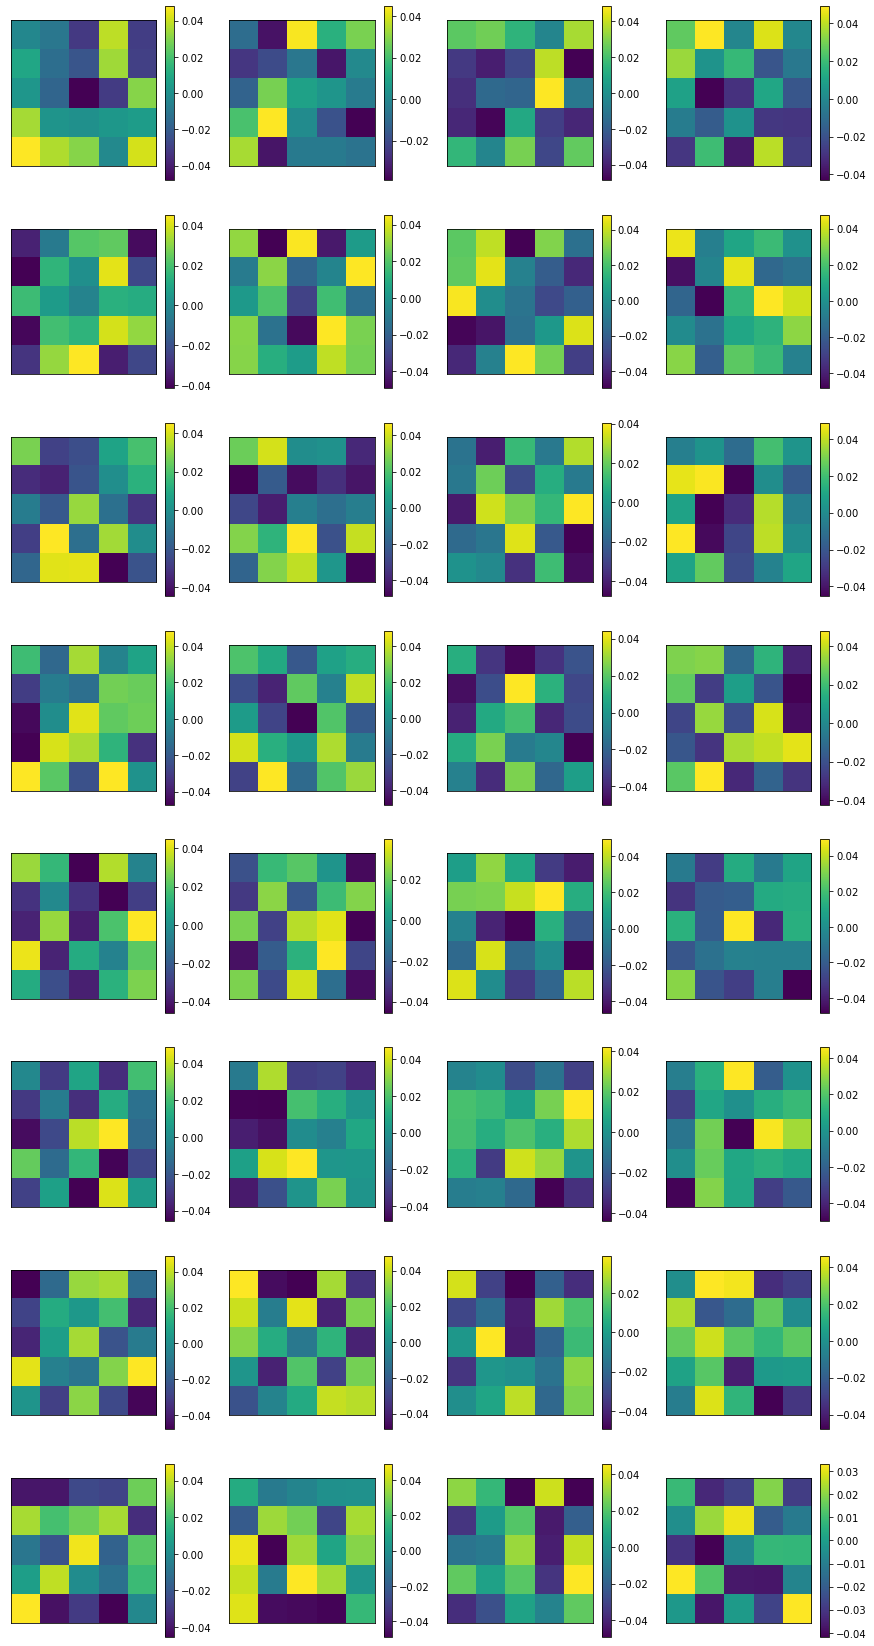

In [173]:
conv2_weights = CIFAR_model.conv2[0].weight.cpu().detach().numpy()

fig, axs = plt.subplots(nrows = 8, ncols=4, figsize=(7,7))
fig.set_size_inches(15, 30)

for filter_id, ax in enumerate(axs.reshape(-1)):

    plot = ax.imshow(conv2_weights[filter_id][0])
    fig.colorbar(plot, ax=ax)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()
